## Chapter 6. Linear Regression and Its Cousins

In [1]:
from rpy2 import robjects
from rpy2.robjects.packages import importr, data
import os
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('mode.chained_assignment',None)
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

In [2]:
base = importr('base')
set_seed = robjects.r("set.seed")
APM = importr('AppliedPredictiveModeling')
APMdatafolder = os.path.expanduser("~/Documents/dataset/AppliedPredictiveModeling/data")
os.path.isdir(APMdatafolder)

True

In [3]:
data_filename='solubility.RData'

In [4]:
#name_ = os.path.splitext(filename)[0]
#name_path = os.path.join(APMdatafolder, name_)
file_path = os.path.join(APMdatafolder, data_filename)

In [5]:
datadict = pyreadr.read_r(file_path)

In [7]:
solTestX, solTestXtrans, solTestY, solTrainX, solTrainXtrans, solTrainY \
= datadict['solTestX'], datadict['solTestXtrans'], datadict['solTestY'], datadict['solTrainX'], datadict['solTrainXtrans'], datadict['solTrainY']

In [8]:
# lowess (local smoother)
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [9]:
def plotContinuousPredictors(X, y, nrows=4, ncols=5):
    '''plot the continous predictors (default 20) versus the outcome'''
    fig, axarr = plt.subplots(nrows, ncols, figsize = (16,9))
    fig.tight_layout()
    
    for r in range(nrows):
        for c in range(ncols):
            plotOnePredictor(axarr[r, c], X.iloc[:,r*ncols+c], y)
            
def plotOnePredictor(ax, X, y):
    '''plot one predictor versus the outcome'''
    z = lowess(np.squeeze(y), np.squeeze(X), 0.88) # return sorted X and y_fit
    ax.scatter(X, y, alpha=0.4)
    ax.plot(z[:, 0], z[:, 1], 'r', linewidth=2)
    ax.set_title(X.name)

In [10]:
contPredictor20List = ['NumRings','NumRotBonds','NumSulfer','SurfaceArea1','SurfaceArea2','NumMultBonds','NumNitrogen','NumNonHAtoms','NumNonHBonds','NumOxygen',\
                      'NumCarbon','NumChlorine','NumDblBonds','NumHalogen','NumHydrogen','HydrophilicFactor','MolWeight','NumAromaticBonds','NumAtoms','NumBonds']

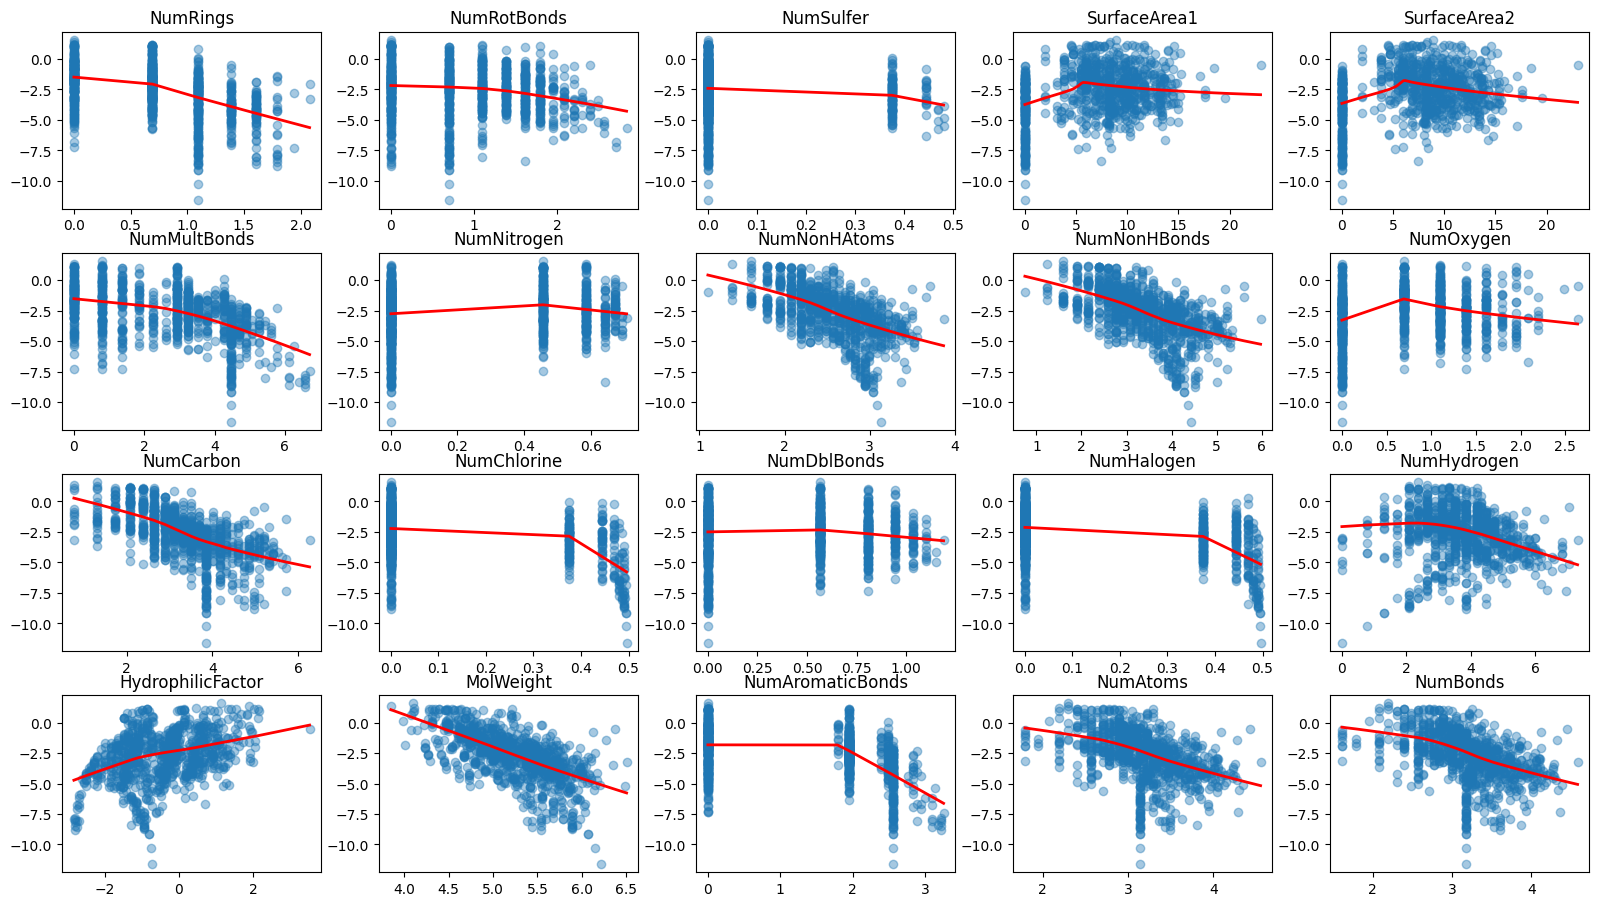

In [11]:
plotContinuousPredictors(solTrainXtrans[contPredictor20List], solTrainY)

<Axes: >

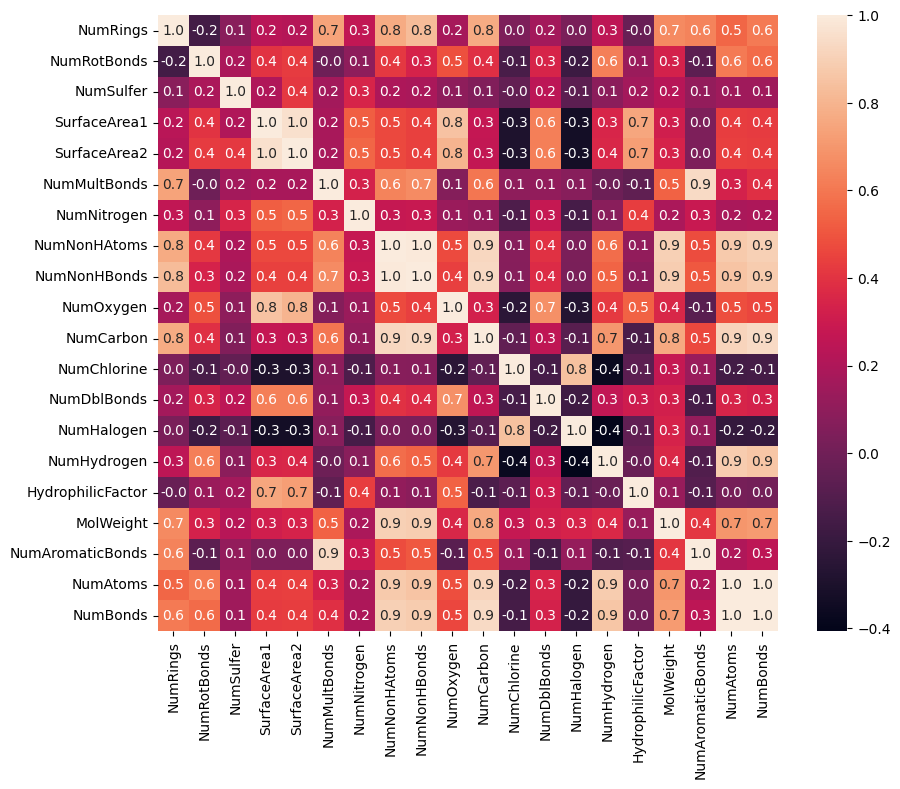

In [12]:
f = plt.figure(figsize=(10,8))
sns.heatmap(solTrainXtrans[contPredictor20List].corr(),annot = True, fmt = ".1f")

Text(0, 0.5, 'Component')

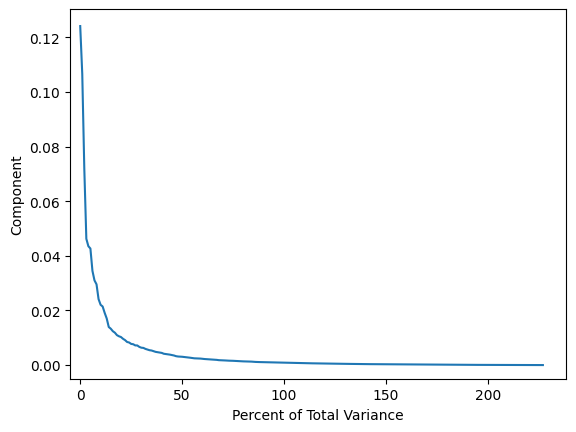

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# scale before PCA
trainX_trans_scale = scale(solTrainXtrans)

pca = PCA()
pca.fit(trainX_trans_scale)

plt.plot(pca.explained_variance_ratio_)
plt.xlim((-5, None))
plt.ylim((-0.005, None))
plt.xlabel('Percent of Total Variance')
plt.ylabel('Component')

In [14]:
def removeHighCorrColumns(XTrain, threshold = 0.9):
    corr_df = XTrain.corr()
    for i in range(len(corr_df)):
        corr_df.iloc[i,i] = 0
    abs_corr = np.abs(np.array(corr_df))
    columnnames = list(corr_df)

    while abs_corr.max() > threshold:
        i, j = np.unravel_index(abs_corr.argmax(), abs_corr.shape)
        #print(i,j, abs_corr.max())
        if abs_corr[i,].mean()> abs_corr[j,].mean():
            k = i
        else:
            k = j
        columnnames.pop(k)
        abs_corr = np.delete(abs_corr, k, axis = 0)
        abs_corr = np.delete(abs_corr, k, axis = 1)
    return columnnames

### Ordinary Linear Regression

In [15]:
solTrainXtrans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Columns: 228 entries, FP001 to SurfaceArea2
dtypes: float64(20), int32(208)
memory usage: 921.4 KB


In [16]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, ShuffleSplit

In [17]:
reg = linear_model.LinearRegression()
reg.fit(solTrainXtrans, solTrainY)

LinearRegression()

In [18]:
np.sqrt(mean_squared_error(solTestY,reg.predict(solTestXtrans))), r2_score(solTestY,reg.predict(solTestXtrans))

(0.7455801896508947, 0.8709146842068276)

In [19]:
cv = ShuffleSplit(n_splits = 10, test_size = 0.1, random_state=0)

lm = linear_model.LinearRegression()
train_scores_mse = cross_val_score(lm, solTrainXtrans, solTrainY, cv=cv, scoring = 'neg_mean_squared_error')
train_scores_rmse = np.sqrt(-1.0 * train_scores_mse)

train_scores_r2 = cross_val_score(lm, solTrainXtrans, solTrainY, cv=cv, scoring = 'r2')

In [20]:
train_scores_rmse, train_scores_r2

(array([0.68718958, 0.69942146, 0.71880894, 0.71203498, 0.64933332,
        0.72064067, 0.61727851, 0.73817555, 0.66834284, 0.76232353]),
 array([0.90122112, 0.89944401, 0.86531833, 0.86458914, 0.90364644,
        0.8673618 , 0.88816774, 0.87395627, 0.88157581, 0.83031673]))

In [21]:
np.mean(train_scores_rmse), np.mean(train_scores_r2)

(0.6973549377790129, 0.8775597385382561)

<Axes: xlabel='predicted', ylabel='residual'>

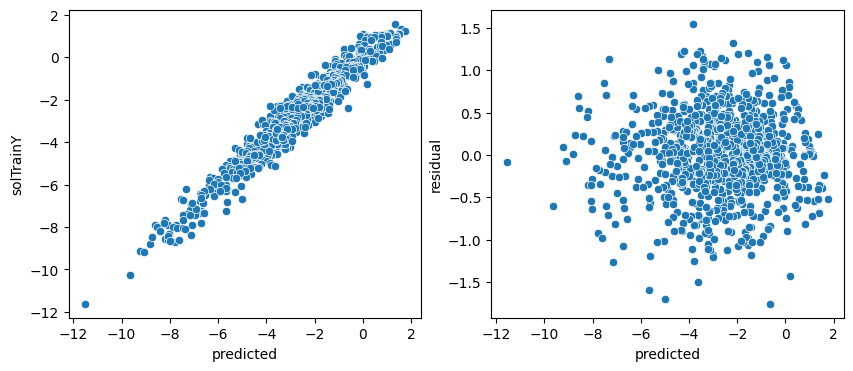

In [22]:
plotdata = solTrainY.copy()
plotdata['predicted'] = reg.predict(solTrainXtrans)
plotdata['residual'] = plotdata['solTrainY']-plotdata['predicted']
f = plt.figure(figsize=(10,4))
ax1 = f.add_subplot(121)
sns.scatterplot(plotdata, x = 'predicted', y='solTrainY',ax = ax1)
ax2 = f.add_subplot(122)
sns.scatterplot(plotdata, x = 'predicted', y='residual',ax = ax2)

In [23]:
remainedCols = removeHighCorrColumns(solTrainXtrans)

In [24]:
XTrainTrans_short = solTrainXtrans[remainedCols]

In [25]:
np.unique(np.array(np.abs(XTrainTrans_short.corr())).flatten())[-2]

0.8969106399505078

In [26]:
regfiltered = linear_model.LinearRegression()

In [27]:
regfiltered.fit(XTrainTrans_short, solTrainY)

LinearRegression()

In [28]:
np.sqrt(mean_squared_error(solTestY,reg.predict(solTestXtrans))), r2_score(solTestY,reg.predict(solTestXtrans))

(0.7455801896508947, 0.8709146842068276)

In [29]:
np.sqrt(mean_squared_error(solTestY,regfiltered.predict(solTestXtrans[remainedCols]))), r2_score(solTestY,regfiltered.predict(solTestXtrans[remainedCols]))

(0.7549948511797723, 0.8676341048261371)

### Partial Least Squares

In [30]:
# RMSEs for 50 components were examined
pcr_rmse = np.zeros([50, 2])
plsr_rmse = np.zeros([50, 2])

In [31]:
def optimal_with_osr(rmse):
    '''Return the minimum RMSE and its # of components using "one-standard error" rule'''
    n_best = np.argmin(rmse[:, 0])
    rmse_min = rmse[n_best, 0] + rmse[n_best, 1]
    n_best = np.min(np.where(rmse[:, 0] <= rmse_min))
    return (n_best+1), rmse_min

In [32]:
# PCR
for n_compo in range(len(pcr_rmse)):
    pca = PCA(n_components= n_compo+1)
    pca_compo = pca.fit_transform(trainX_trans_scale)
    train_scores_mse = cross_val_score(linear_model.LinearRegression(), pca_compo, solTrainY, cv=cv, scoring = 'neg_mean_squared_error')
    pcr_rmse[n_compo, 0] = np.mean(np.sqrt(-1.0 * train_scores_mse))
    pcr_rmse[n_compo, 1] = np.std(np.sqrt(-1.0 * train_scores_mse))

n_best, rmse_min = optimal_with_osr(pcr_rmse)
print(f"With one-standard error rule, the minimum PCR RMSE is {rmse_min} with {n_best} components")

With one-standard error rule, the minimum PCR RMSE is 0.8959292521172473 with 36 components


In [33]:
# PLSR
from sklearn.cross_decomposition import PLSRegression

for n_compo in range(len(plsr_rmse)):
    plsr= PLSRegression(n_components= n_compo+1, scale=False)
    train_scores_mse = cross_val_score(plsr, trainX_trans_scale, solTrainY, cv=cv, scoring = 'neg_mean_squared_error')
    plsr_rmse[n_compo, 0] = np.mean(np.sqrt(-1.0 * train_scores_mse))
    plsr_rmse[n_compo, 1] = np.std(np.sqrt(-1.0 * train_scores_mse))

n_best, rmse_min = optimal_with_osr(plsr_rmse)
print(f"With one-standard error rule, the minimum PLSR RMSE is {rmse_min} with {n_best} components")

With one-standard error rule, the minimum PLSR RMSE is 0.729459139068576 with 10 components


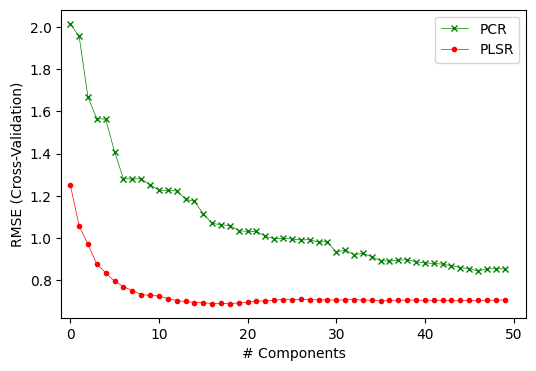

In [34]:
f = plt.figure(figsize=(6,4))
plt_pcr, = plt.plot(pcr_rmse[:,0], '-x', c= 'green', linewidth = 0.5,ms =5)
plt_plsr, = plt.plot(plsr_rmse[:,0], '-o', c= 'red', linewidth = 0.5, ms = 3)
plt.xlim((-1, None))
plt.xlabel("# Components")
plt.ylabel("RMSE (Cross-Validation)")
plt.legend([plt_pcr, plt_plsr], ['PCR', 'PLSR'])

In [35]:
from scipy.stats import pearsonr

# compoare the first two components
pca2 = PCA(n_components=2)
pca2.fit(trainX_trans_scale)

plsr2 = PLSRegression(n_components=2, scale=False)
plsr2.fit(trainX_trans_scale, solTrainY)

PLSRegression(scale=False)

Text(0.06, 0.5, 'Solubility')

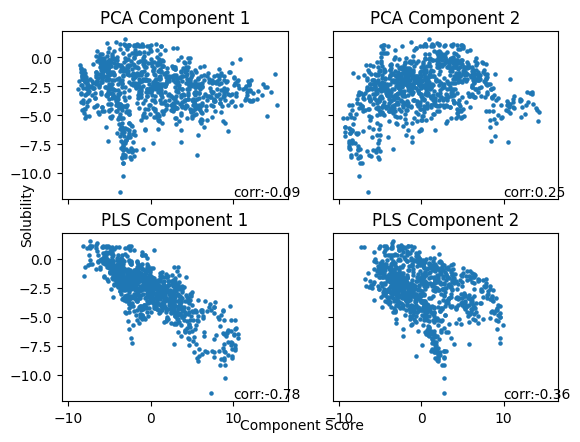

In [36]:
# visulization
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
#fig.tight_layout()

axarr[0,0].scatter(pca2.transform(trainX_trans_scale)[:, 0], solTrainY, s=5)
axarr[0,0].set_title("PCA Component 1")
corr = pd.DataFrame({'X':pca2.transform(trainX_trans_scale)[:,0], 'Y':solTrainY['solTrainY']}).corr().iloc[0,1]
axarr[0,0].text(10, -12, 'corr:' + str(round(corr, 2)))

axarr[0,1].scatter(pca2.transform(trainX_trans_scale)[:, 1], solTrainY, s=5)
axarr[0,1].set_title("PCA Component 2")
corr = pd.DataFrame({'X':pca2.transform(trainX_trans_scale)[:,1], 'Y':solTrainY['solTrainY']}).corr().iloc[0,1]
axarr[0,1].text(10, -12, 'corr:' + str(round(corr, 2)))

axarr[1,0].scatter(plsr2.transform(trainX_trans_scale)[:, 0], solTrainY,s=5)
axarr[1,0].set_title("PLS Component 1")
corr = pd.DataFrame({'X':plsr2.transform(trainX_trans_scale)[:,0], 'Y':solTrainY['solTrainY']}).corr().iloc[0,1]
axarr[1,0].text(10, -12, 'corr:' + str(round(corr, 2)))

axarr[1,1].scatter(plsr2.transform(trainX_trans_scale)[:, 1], solTrainY,s=5)
axarr[1,1].set_title("PLS Component 2")
corr = pd.DataFrame({'X':plsr2.transform(trainX_trans_scale)[:,1], 'Y':solTrainY['solTrainY']}).corr().iloc[0,1]
axarr[1,1].text(10, -12, 'corr:' + str(round(corr, 2)))

fig.text(0.5, 0.06, 'Component Score', ha='center', va='center')
fig.text(0.06, 0.5, 'Solubility', va='center', rotation='vertical')

In [37]:
testX_trans_scale = scale(solTestXtrans)

# PCR
pca = PCA(n_components=37) # optimal
pca.fit(trainX_trans_scale)
trainX_pca = pca.transform(trainX_trans_scale)
testX_pca = pca.transform(testX_trans_scale)
lm = linear_model.LinearRegression()
lm.fit(trainX_pca, solTrainY)
testY_pca_pred = lm.predict(testX_pca)

# PLSR
plsr = PLSRegression(n_components=10, scale=False)
plsr.fit(trainX_trans_scale, solTrainY)
testY_plsr_pred = plsr.predict(testX_trans_scale)

<Axes: xlabel='predicted', ylabel='residual'>

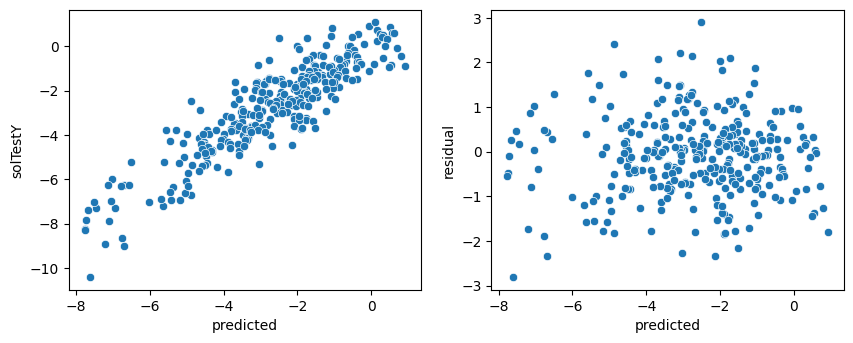

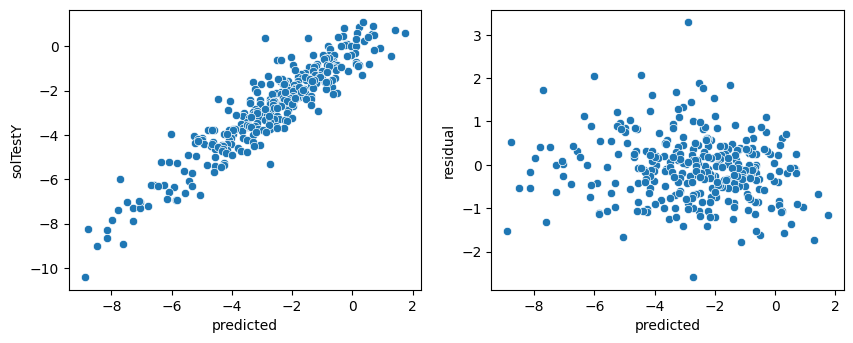

In [38]:
plotdata = solTestY.copy()
plotdata['predicted'] = testY_pca_pred
plotdata['residual'] = plotdata['solTestY']-plotdata['predicted']
f = plt.figure(figsize=(10,8))
ax1 = f.add_subplot(221)
sns.scatterplot(plotdata, x = 'predicted', y='solTestY',ax = ax1)
ax2 = f.add_subplot(222)
sns.scatterplot(plotdata, x = 'predicted', y='residual',ax = ax2)

plotdata['predicted'] = testY_plsr_pred
plotdata['residual'] = plotdata['solTestY']-plotdata['predicted']
f = plt.figure(figsize=(10,8))
ax3 = f.add_subplot(223)
sns.scatterplot(plotdata, x = 'predicted', y='solTestY',ax = ax3)
ax4 = f.add_subplot(224)
sns.scatterplot(plotdata, x = 'predicted', y='residual',ax = ax4)

### Penalized Models

Text(0, 0.5, 'Standardized Coefficient')

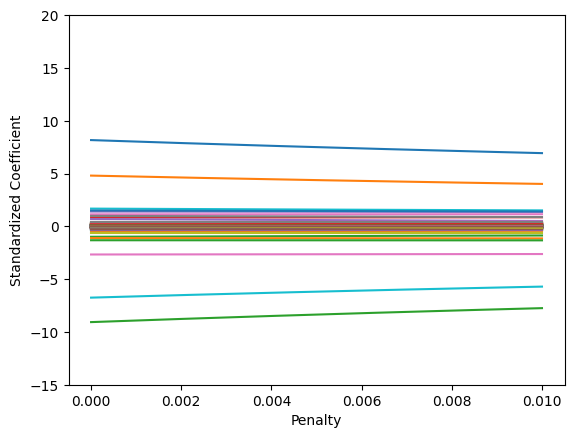

In [39]:
# path of the ridge regression coefficients
from sklearn.linear_model import Ridge

lambda_range = np.linspace(0.0, 0.01, 600)
ridgeModel = Ridge()
coeff_path = []

for a in lambda_range:
    ridgeModel.set_params(alpha = a)
    ridgeModel.fit(trainX_trans_scale, solTrainY)
    coeff_path.append(ridgeModel.coef_[0])

ax=plt.gca()
plt.plot(lambda_range, coeff_path)
ax.set_xlim(-0.0005, 0.0105)
ax.set_ylim(-15,20)
plt.xlabel("Penalty")
plt.ylabel("Standardized Coefficient")

(-0.005, 0.105)

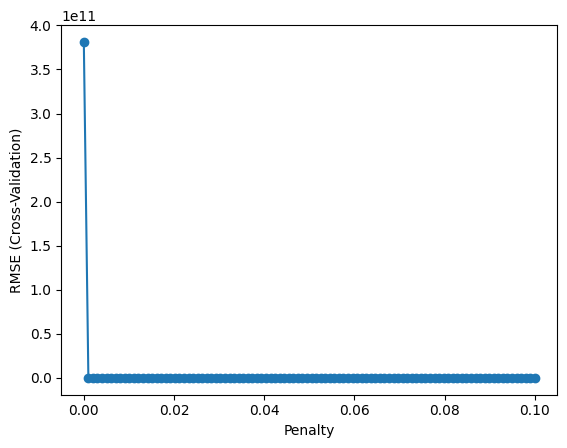

In [40]:
# penalty value versus RMSE
lambda_range = np.linspace(0.0, 0.1, 100)
score_rmse = np.zeros(100)

ridgeModel = Ridge()
for adx, a in enumerate(lambda_range):
    temp_scores = cross_val_score(ridgeModel.set_params(alpha = a),
                                  trainX_trans_scale, solTrainY,
                                  cv=cv, scoring="neg_mean_squared_error")
    temp_scores = np.sqrt(-1.0 * temp_scores)
    score_rmse[adx] = np.mean(temp_scores)
    
plt.plot(lambda_range, score_rmse, '-o')
plt.xlabel("Penalty")
plt.ylabel("RMSE (Cross-Validation)")
plt.xlim((-0.005, 0.105))

In [41]:
np.array(solTrainY)[:,0].shape

(951,)

.

Text(0, 0.5, 'Standardized Coefficient')

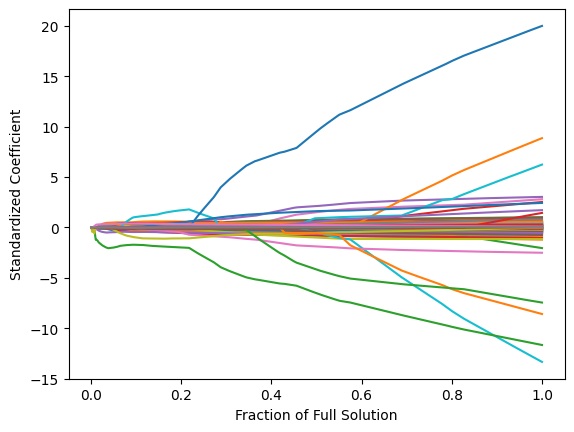

In [42]:
# path of the lasso regression coefficients
from sklearn.linear_model import lars_path

# compute regularization path using the LARS
lambdas, _, coefs = lars_path(np.array(solTrainXtrans), np.array(solTrainY)[:,0], method = 'lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
plt.xlabel('Fraction of Full Solution')
plt.ylabel('Standardized Coefficient')

### Using Statsmodel package for model summary

In [43]:
import statsmodels.api as sm
X = sm.add_constant(solTrainXtrans)
results = sm.OLS(solTrainY,X).fit()
summary = results.summary()
r2_score(solTestY,results.predict(sm.add_constant(solTestXtrans)))

0.8709146842068277

In [44]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              solTrainY   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     54.03
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:01:07   Log-Likelihood:                -654.04
No. Observations:                 951   AIC:                             1766.
Df Residuals:                     722   BIC:                             2878.
Df Model:                         228                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.4307      2.162      1.124      0.261      -1.814       6.676
FP001                 0.3594      0.319      1.128      0.260      -0.266       0.985
FP002                 0.1456      0.264      0.552      0.581      -0.372       0.663
FP003                -0.0397      0.131     -0.302      0.763      -0.298       0.218
FP004                -0.3049      0.137     -2.223      0.027      -0.574      -0.036
FP005                 2.8367      0.960      2.956      0.003       0.952       4.721
FP006                -0.0689      0.204     -0.337      0.736      -0.470       0.332
FP007                 0.0404      0.115      0.351      0.726      -0.186       0.267
FP008                 0.1121      0.164      0.685      0.493      -0.209       0.433
FP009                -0.8242      0.840     -0.982      0.327      -2.472       0.824
FP010                 0.4193      0.314      1.337      0.182      -0.196       1.035
FP011                 0.0516      0.220      0.235      0.815      -0.380       0.483
FP012                -0.0135      0.161     -0.084      0.933      -0.330       0.303
FP013                -0.4519      0.547     -0.826      0.409      -1.526       0.623
FP014                 0.3281      0.455      0.721      0.471      -0.565       1.221
FP015                -0.1839      0.152     -1.209      0.227      -0.483       0.115
FP016                -0.1367      0.155     -0.883      0.377      -0.441       0.167
FP017                -0.1704      0.139     -1.230      0.219      -0.443       0.102
FP018                -0.3824      0.239     -1.602      0.110      -0.851       0.086
FP019                -0.3131      0.386     -0.811      0.418      -1.071       0.445
FP020                 0.2072      0.213      0.971      0.332      -0.212       0.626
FP021                -0.0596      0.263     -0.226      0.821      -0.576       0.457
FP022                 0.2336      0.346      0.676      0.499      -0.445       0.912
FP023                -0.3193      0.191     -1.672      0.095      -0.694       0.056
FP024                -0.4272      0.283     -1.511      0.131      -0.982       0.128
FP025                 0.4376      0.454      0.964      0.335      -0.453       1.329
FP026                 0.2068      0.256      0.806      0.420      -0.297       0.710
FP027                 0.2424      0.243      0.998      0.319      -0.234       0.719
FP028                 0.1070      0.120      0.892      0.373      -0.128       0.343
FP029                -0.0986      0.220     -0.448      0.654      -0.530       0.333
FP030                -0.2361      0.247     -0.957      0.339      -0.721       0.248
FP031                 0.0869      0.135      0.646      0.519      -0.177       0.351
FP032                -1.2045      0.777     -1.550      0.122      -2.730